In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

## using logical reg

In [2]:
df = pd.read_csv('../data/cleaned-premier-onehot.csv')

In [3]:
def get_outcome(row):
    if row["home_outcome_W"] == 1:
        return 2  # win
    elif row["home_outcome_D"] == 1:
        return 1  # draw
    elif row["home_outcome_L"] == 1:
        return 0  # loss

df["match_result"] = df.apply(get_outcome, axis=1)

### New features to help prediction

In [4]:
df["ranking_diff"] = abs(df["home_ranking"] - df["away_ranking"])
df["form_diff"] = abs(
    (df["home_season_wins_so_far"] - df["home_season_losses_so_far"]) -
    (df["away_season_wins_so_far"] - df["away_season_losses_so_far"])
)
df["odds_ratio"] = df["avg_odd_home_win"] / df["avg_odd_away_win"]

df["draw_margin"] = df["avg_odd_draw"] - ((df["avg_odd_home_win"] + df["avg_odd_away_win"]) / 2)

df["is_balanced_match"] = (
    (df["ranking_diff"].abs() <= 2) &
    (df["form_diff"].abs() <= 2)
).astype(int)

In [5]:
features = [
    "avg_odd_home_win", "avg_odd_draw", "home_ranking",
    "home_season_draws_so_far", "home_season_losses_so_far",
    "away_season_wins_so_far", "form_diff", "ranking_diff", "odds_ratio", "is_balanced_match"
]

scale the data

In [6]:
X = df[features]
y = df["match_result"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

train the model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## validate the model

In [9]:
y_pred = model.predict(X_test)

In [10]:
print("\nFeatures used:")
for f in features:
    print(" -", f)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Features used:
 - avg_odd_home_win
 - avg_odd_draw
 - home_ranking
 - home_season_draws_so_far
 - home_season_losses_so_far
 - away_season_wins_so_far
 - form_diff
 - ranking_diff
 - odds_ratio
 - is_balanced_match

Confusion Matrix:
[[35  0 41]
 [ 9  3 53]
 [17  3 89]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        76
           1       0.50      0.05      0.08        65
           2       0.49      0.82      0.61       109

    accuracy                           0.51       250
   macro avg       0.52      0.44      0.40       250
weighted avg       0.52      0.51      0.44       250



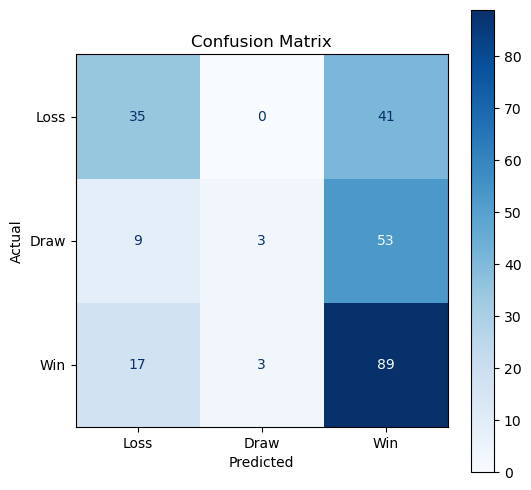

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Draw", "Win"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [40]:
coef_df = pd.DataFrame(model.coef_, columns=features, index=["Loss", "Draw", "Win"])
print("\nLogistic Regression Coefficients:")
print(coef_df.T.round(3))


Logistic Regression Coefficients:
                            Loss   Draw    Win
avg_odd_home_win          -0.008 -0.125  0.133
avg_odd_draw               0.137 -0.196  0.058
home_ranking               0.050 -0.026 -0.024
home_season_draws_so_far   0.056 -0.061  0.005
home_season_losses_so_far  0.029  0.013 -0.042
away_season_wins_so_far   -0.107 -0.023  0.130
form_diff                 -0.062  0.108 -0.047
ranking_diff              -0.035 -0.088  0.124
odds_ratio                 0.452  0.066 -0.518
is_balanced_match         -0.020 -0.023  0.043


### Model Behavior Analysis

---

#### Prediction Bias

- The model is heavily biased toward predicting wins (`2`).
- It misclassifies draws (`1`) the most: only 5 out of 65 draws were predicted correctly.
- Losses (`0`) are often confused with wins: 40 out of 76 actual losses were predicted as wins.
- Wins (`2`) are most accurately predicted, with a recall of 81% (88/109).

---

#### Draws Are Being Ignored
  
It seems like logistic regression struggles to find a clear boundary that separates draws from wins and losses, especially with the features used.

---

#### Overprediction of Wins

The model tends to favor win predictions, possibly because features like:

- `odds_ratio`
- `ranking_diff`
- `form_diff`

are more informative in separating wins from losses, but not so much for draws.

---

#### Accuracy Is Misleading

While the model achieves 52% accuracy, this number is deceptive:  
The high accuracy comes from overpredicting the most common class (wins) — leading to poor balance and low recall for draws and losses.

---


In [41]:
joblib.dump(model, '../Models/logical-reg-model.pkl')

['../Models/logical-reg-model.pkl']